https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/data_preview


In [1]:
!python.exe -m pip install --upgrade pip

/bin/bash: line 1: python.exe: command not found


In [ ]:
!pip install plotly

#Front-end dependencies
!pip install dash

# Just to get a progress bar, not implemented
!sudo apt-get install -y aria2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import plotly.express as px

In [3]:
# Do not click the links, the datasets are very very large
# About 3 minutes of runtime on desktop devices
crashes_url = 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessTypedownload'
persons_url = 'https://data.cityofnewyork.us/api/views/f55k-p6yu/rows.csv?accessType=download'

df_crashes = pd.read_csv(crashes_url,low_memory = False)
df_persons = pd.read_csv (persons_url,low_memory = False)

============================================
Member 2 — Pre-Integration Cleaning (Steps 3–8)
============================================

In [ ]:
# ---------------------------
# Step 3: Build real datetimes + helpers
# ---------------------------

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found in {list(df.columns)[:12]} ...")

def build_datetime(df, date_candidates, time_candidates, out_col):
    # Resolve actual names present in this DataFrame
    date_col = pick_col(df, date_candidates)
    time_col = pick_col(df, time_candidates)

    time_clean = df[time_col].astype("string").str.strip()
    date_parsed = pd.to_datetime(df[date_col], errors="coerce")

    # parse time (HH:MM, then HH:MM:SS fallback)
    time_parsed = pd.to_datetime(time_clean, format="%H:%M", errors="coerce").dt.time
    need_fallback = time_parsed.isna() & time_clean.notna()
    if need_fallback.any():
        time_parsed_fallback = pd.to_datetime(time_clean, format="%H:%M:%S", errors="coerce").dt.time
        time_parsed = time_parsed.fillna(time_parsed_fallback)

    combined = pd.to_datetime(date_parsed.dt.date.astype("string") + " " + time_clean, errors="coerce")

    df["crash_date_parsed"] = date_parsed.dt.date  # name is okay (used only for debug/peek)
    df["crash_time_parsed"] = time_parsed
    df[out_col] = combined

    # helpers required by milestone
    prefix = out_col.split("_", 1)[0]
    df[f"{prefix}_year"]  = df[out_col].dt.year
    df[f"{prefix}_month"] = df[out_col].dt.month
    df[f"{prefix}_hour"]  = df[out_col].dt.hour

    total = len(df)
    ok = df[out_col].notna().sum()
    print(f"Built {out_col}: {ok}/{total} rows parsed ({ok/total:.1%}).")
    if ok > 0:
        print("Year range:", int(df[out_col].dt.year.min()), "to", int(df[out_col].dt.year.max()))
    return df

# Apply to BOTH tables (robust to column-name variants)
df_crashes = build_datetime(
    df_crashes,
    date_candidates=["CRASH DATE", "CRASH_DATE", "crash_date"],
    time_candidates=["CRASH TIME", "CRASH_TIME", "crash_time"],
    out_col="crash_datetime"
)

df_persons = build_datetime(
    df_persons,
    date_candidates=["CRASH DATE", "CRASH_DATE", "crash_date"],
    time_candidates=["CRASH TIME", "CRASH_TIME", "crash_time"],
    out_col="person_datetime"
)


In [ ]:
# ---------------------------
# Step 4: Coordinate sanity (flags only, do NOT drop here)
# ---------------------------

def _pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found in {list(df.columns)[:12]} ...")

NYC_LAT_MIN, NYC_LAT_MAX = 40.4774, 40.9176
NYC_LON_MIN, NYC_LON_MAX = -74.2591, -73.7004

lat_col = _pick_col(df_crashes, ["LATITUDE", "latitude"])
lon_col = _pick_col(df_crashes, ["LONGITUDE", "longitude"])

df_crashes["latitude_num"]  = pd.to_numeric(df_crashes[lat_col], errors="coerce")
df_crashes["longitude_num"] = pd.to_numeric(df_crashes[lon_col], errors="coerce")

lat_missing = df_crashes["latitude_num"].isna()
lon_missing = df_crashes["longitude_num"].isna()
lat_zero    = df_crashes["latitude_num"].eq(0)
lon_zero    = df_crashes["longitude_num"].eq(0)
lat_oob     = df_crashes["latitude_num"].notna() & ~df_crashes["latitude_num"].between(NYC_LAT_MIN, NYC_LAT_MAX, inclusive="both")
lon_oob     = df_crashes["longitude_num"].notna() & ~df_crashes["longitude_num"].between(NYC_LON_MIN, NYC_LON_MAX, inclusive="both")

df_crashes["coord_issue"] = lat_missing | lon_missing | lat_zero | lon_zero | lat_oob | lon_oob

def _coord_reason(row):
    reasons = []
    if pd.isna(row["latitude_num"]):  reasons.append("lat_missing")
    if pd.isna(row["longitude_num"]): reasons.append("lon_missing")
    if pd.notna(row["latitude_num"])  and row["latitude_num"]  == 0: reasons.append("lat_zero")
    if pd.notna(row["longitude_num"]) and row["longitude_num"] == 0: reasons.append("lon_zero")
    if pd.notna(row["latitude_num"])  and (row["latitude_num"]  < NYC_LAT_MIN or row["latitude_num"]  > NYC_LAT_MAX):
        reasons.append("lat_out_of_bounds")
    if pd.notna(row["longitude_num"]) and (row["longitude_num"] < NYC_LON_MIN or row["longitude_num"] > NYC_LON_MAX):
        reasons.append("lon_out_of_bounds")
    return "|".join(reasons) if reasons else ""

df_crashes["coord_issue_reason"] = df_crashes.apply(_coord_reason, axis=1)

total = int(len(df_crashes))
bad   = int(df_crashes["coord_issue"].sum())
print(f"Coordinate sanity — good: {total-bad}/{total} ({(total-bad)/total:.1%}), issues: {bad} ({bad/total:.1%})")
display(
    df_crashes["coord_issue_reason"]
      .replace("", "ok").value_counts().head(10).to_frame("rows")
)

In [ ]:
# ---------------------------
# Step 5: Make key columns consistent (IN-PLACE, keep uppercase names)
# ---------------------------

VALID_BOROUGHS = {"BROOKLYN","QUEENS","MANHATTAN","BRONX","STATEN ISLAND"}

# ZIP in crashes → exactly 5 digits (string)
if "ZIP CODE" in df_crashes.columns:
    z = df_crashes["ZIP CODE"].astype("string")
    df_crashes["ZIP CODE"] = z.str.extract(r"(\d{5})", expand=False).astype("string")

# BOROUGH in crashes: uppercase + valid set (others -> NaN)
if "BOROUGH" in df_crashes.columns:
    b = df_crashes["BOROUGH"].astype("string").str.strip().str.upper()
    b = b.replace({"STATEN IS": "STATEN ISLAND", "SI": "STATEN ISLAND"})
    df_crashes["BOROUGH"] = b.where(b.isin(VALID_BOROUGHS))

# IDs → string, keep column names uppercase
if "COLLISION_ID" in df_crashes.columns:
    df_crashes["COLLISION_ID"] = pd.to_numeric(df_crashes["COLLISION_ID"], errors="coerce").astype("Int64").astype("string")

for col in ["UNIQUE_ID", "COLLISION_ID", "PERSON_ID", "VEHICLE_ID"]:
    if col in df_persons.columns:
        df_persons[col] = pd.to_numeric(df_persons[col], errors="coerce").astype("Int64").astype("string")

# Age in persons
if "PERSON_AGE" in df_persons.columns:
    a = pd.to_numeric(df_persons["PERSON_AGE"], errors="coerce")
    df_persons["PERSON_AGE"] = a.where((a >= 0) & (a <= 120)).astype("Int64")


In [ ]:
# ---------------------------
# Step 6: Duplicates (exact, then key-based)
# ---------------------------

c_before = len(df_crashes)
df_crashes = df_crashes.drop_duplicates()
print(f"Crashes — exact dupes removed: {c_before - len(df_crashes)} (from {c_before} to {len(df_crashes)})")

p_before = len(df_persons)
df_persons = df_persons.drop_duplicates()
print(f"Persons — exact dupes removed: {p_before - len(df_persons)} (from {p_before} to {len(df_persons)})")

if "COLLISION_ID" in df_crashes.columns:
    c_before_keys = len(df_crashes)
    df_crashes = df_crashes.drop_duplicates(subset=["COLLISION_ID"], keep="first")
    print(f"Crashes — key dupes on COLLISION_ID removed: {c_before_keys - len(df_crashes)}")
    print("   COLLISION_ID unique now?", df_crashes["COLLISION_ID"].duplicated().sum() == 0)

if "UNIQUE_ID" in df_persons.columns:
    p_before_keys = len(df_persons)
    df_persons = df_persons.drop_duplicates(subset=["UNIQUE_ID"], keep="first")
    print(f"Persons — key dupes on UNIQUE_ID removed: {p_before_keys - len(df_persons)}")
    print("   UNIQUE_ID unique now?", df_persons["UNIQUE_ID"].duplicated().sum() == 0)


In [ ]:
# ---------------------------
# Step 7: Missing values (drop required, impute optional)
# ---------------------------

def col_exists(df, name): return name in df.columns

print("Before — rows:", len(df_crashes), "(crashes),", len(df_persons), "(persons)")

crash_required  = ["COLLISION_ID", "crash_datetime"]
person_required = ["UNIQUE_ID", "COLLISION_ID", "person_datetime"]

crash_drop_mask  = pd.Series(False, index=df_crashes.index)
for c in crash_required:
    if col_exists(df_crashes, c):
        crash_drop_mask |= df_crashes[c].isna()
crashes_to_drop  = int(crash_drop_mask.sum())

person_drop_mask = pd.Series(False, index=df_persons.index)
for c in person_required:
    if col_exists(df_persons, c):
        person_drop_mask |= df_persons[c].isna()
persons_to_drop = int(person_drop_mask.sum())

df_crashes = df_crashes.loc[~crash_drop_mask].copy()
df_persons = df_persons.loc[~person_drop_mask].copy()

print(f"Dropped (missing required) — crashes: {crashes_to_drop}, persons: {persons_to_drop}")
print("After drops — rows:", len(df_crashes), "(crashes),", len(df_persons), "(persons)")

# Impute non-critical categoricals
if col_exists(df_crashes, "BOROUGH"):
    filled = int(df_crashes["BOROUGH"].isna().sum())
    df_crashes["BOROUGH"] = df_crashes["BOROUGH"].fillna("UNKNOWN").str.strip()
    print(f"Imputed crashes.BOROUGH → 'UNKNOWN': {filled} rows")

for col, val in [("PERSON TYPE", "Unknown"), ("PERSON INJURY", "Unknown")]:
    if col_exists(df_persons, col):
        filled = int(df_persons[col].isna().sum())
        df_persons[col] = df_persons[col].fillna(val).str.strip()
        print(f"Imputed persons.{col} → '{val}': {filled} rows")

if col_exists(df_persons, "PERSON SEX"):
    filled = int(df_persons["PERSON SEX"].isna().sum())
    df_persons["PERSON SEX"] = df_persons["PERSON SEX"].fillna("U").str.strip()
    print(f"Imputed persons.PERSON SEX → 'U': {filled} rows")

# Numeric impute (age) with median
if col_exists(df_persons, "PERSON_AGE"):
    age_median = float(df_persons["PERSON_AGE"].median(skipna=True))
    filled = int(df_persons["PERSON_AGE"].isna().sum())
    df_persons["PERSON_AGE"] = df_persons["PERSON_AGE"].fillna(age_median)
    print(f"Imputed persons.PERSON_AGE → median {age_median:.1f}: {filled} rows")

print("Done: missing-value handling (simple policy).")


In [ ]:
# ---------------------------
# Step 7b / 8: Domain outliers (address gently, then validate)
# ---------------------------

# Coordinates → set flagged/missing/out-of-box to NaN (no dropping)
lat_cand = [c for c in ["LATITUDE", "latitude"] if c in df_crashes.columns]
lon_cand = [c for c in ["LONGITUDE", "longitude"] if c in df_crashes.columns]
if lat_cand and lon_cand:
    if "coord_issue" in df_crashes.columns:
        bad_coord_mask = df_crashes["coord_issue"].astype(bool)
    else:
        lat_num = pd.to_numeric(df_crashes[lat_cand[0]], errors="coerce")
        lon_num = pd.to_numeric(df_crashes[lon_cand[0]], errors="coerce")
        lat_lo, lat_hi = 40.40, 41.00
        lon_lo, lon_hi = -74.30, -73.60
        bad_coord_mask = (
            lat_num.isna() | lon_num.isna() |
            (lat_num < lat_lo) | (lat_num > lat_hi) |
            (lon_num < lon_lo) | (lon_num > lon_hi)
        )
    coord_fixed = int(bad_coord_mask.sum())
    df_crashes.loc[bad_coord_mask, [lat_cand[0], lon_cand[0]]] = pd.NA
    print(f"Coordinates set to NaN due to out-of-bounds/missing: {coord_fixed} rows")

# Age impossible → NaN (guard)
if col_exists(df_persons, "PERSON_AGE"):
    df_persons["PERSON_AGE"] = pd.to_numeric(df_persons["PERSON_AGE"], errors="coerce")
    age_lo, age_hi = 0, 110
    out_age = (df_persons["PERSON_AGE"] < age_lo) | (df_persons["PERSON_AGE"] > age_hi)
    out_age_count = int(out_age.fillna(False).sum())
    if out_age_count > 0:
        df_persons.loc[out_age, "PERSON_AGE"] = pd.NA
        print(f"Persons age set to NaN (outside [{age_lo},{age_hi}]): {out_age_count} rows")

# Year sanity (2012..2025)
if "crash_datetime" in df_crashes.columns:
    year_min, year_max = 2012, 2025
    years = df_crashes["crash_datetime"].dt.year
    bad_year_mask = (years < year_min) | (years > year_max)
    dropped_bad_years = int(bad_year_mask.sum())
    if dropped_bad_years > 0:
        df_crashes = df_crashes.loc[~bad_year_mask].copy()
    print(f"Dropped crashes with year outside [{year_min},{year_max}]: {dropped_bad_years}")

# Count columns non-negative (NYC naming uses "NUMBER OF ...")
count_cols = [c for c in df_crashes.columns if c.upper().startswith("NUMBER OF ")]
neg_total = 0
for c in count_cols:
    if pd.api.types.is_numeric_dtype(df_crashes[c]):
        negs = int((df_crashes[c] < 0).sum())
        if negs > 0:
            df_crashes[c] = df_crashes[c].clip(lower=0)
            neg_total += negs
print(f"Crash count columns clipped from negative to zero (if any remained): {neg_total}")

print("Done: Step 3–8 (pre-integration cleaning).")

In [10]:
def title(s):
  print("="*60)
  print(s)
  print("="*60)

def findNulls(df):
  total = df.size
  nulls = df.isna().sum().sum()
  p = (nulls / total) * 100
  print(f"Percentage of null data in the following dataset = {p:.2f}%")

  return p

def getIndividualNulls(df):
  nulls = df.isna().sum()
  nulls = nulls[nulls>0]
  print(nulls.apply(lambda x: f"{x:,}"))
  return nulls

def removeDupes(df):
  print(f"Before removing duplicates: {df.shape}")
  df.drop_duplicates(inplace=True)
  print(f"After removing  duplicates: {df.shape}\n")
  return df

def cleanOutliers(df):
  numeric_cols = df.select_dtypes(include=[np.number]).columns
  mask = pd.Series(True, index=df.index)

  for column in numeric_cols:
    if column == 'COLLISION_ID':
      continue
    q1  = df[column].quantile(0.25)
    q3  = df[column].quantile(0.75)
    iqr = q3-q1
    lower = q1-1.5*iqr
    upper = q3+1.5*iqr
    mask &= df[column].between(lower,upper)|df[column].isna()

  return df[mask]

def outlierComparison(df):
  print("before Outliers:")
  temp = findNulls(df)
  print("\nAfter Outliers")
  cleanOutliers(df)
  diff = temp-findNulls(df)

  if diff>0:
    print(f"Percentage of nulls decreased by = {diff:.8f}%")
  else:
    print("no outliers... for some reason")

  return df

def datasetOverview(df):
  print(f"Size: {df.size:,}")
  print(f"Shape: {df.shape}")
  print(f"Columns: {df.columns}")

  getIndividualNulls(df)

  total = df.size
  nulls = df.isna().sum().sum()
  p = (nulls / total) * 100
  print(f"Percentage of null data = {p:.4f}%\n")

def cleanData(df):
  df = removeDupes(df)
  df = outlierComparison(df)
  return df

In [11]:
title("Crashes - Data Overview")
datasetOverview(df_crashes)

title("Persons - Data Overview")
datasetOverview(df_persons)

Crashes - Data Overview
Size: 64,340,299
Shape: (2218631, 29)
Columns: Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')
BOROUGH                            679,907
ZIP CODE                           680,182
LATITUDE                           240,341
LONGITUDE           

In [ ]:
title("Crashes - Data Cleaning")
df_crashes=cleanData(df_crashes)

title("Persons - Data Cleaning")
df_persons=cleanData(df_persons)

In [13]:
df_merged = pd.merge(df_crashes, df_persons, on="COLLISION_ID", how="inner")
title("Merged - Data Overview")
datasetOverview(df_merged)

Merged - Data Overview
Size: 284,877,180
Shape: (5813820, 49)
Columns: Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'UNIQUE_ID', 'CRASH_DATE', 'CRASH_TIME', 'PERSON_ID', 'PERSON_TYPE',
       'PERSON_INJURY', 'VEHICLE_ID', 'PERSON_AGE', 'EJECTION',
       'EMOTIONAL_STATUS', 'BODI

In [14]:
df_merged=cleanData(df_merged)

Before removing duplicates: (5813820, 49)
After removing  duplicates: (5813820, 49)

before Outliers:
Percentage of null data in the following dataset = 31.77%

After Outliers
Percentage of null data in the following dataset = 31.77%
no outliers... for some reason


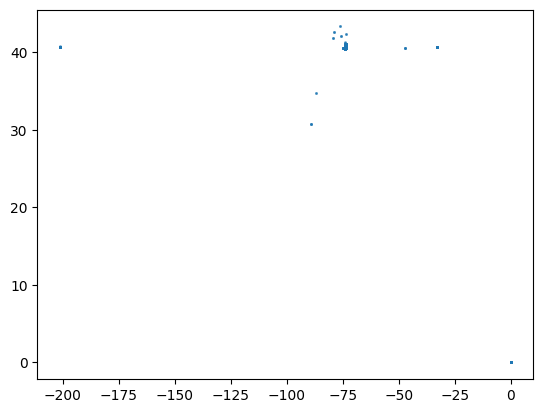

In [15]:
plt.scatter(df_merged['LONGITUDE'], df_merged['LATITUDE'], s=1, alpha=0.3)
plt.show()

In [ ]:
#Front end